In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True
def my_obj(preds, train_data):
    labels = train_deata.get_label()

In [4]:
train = pd.read_csv('../data/public_raw.train.csv')
test = pd.read_csv('../data/public_raw.test.csv')

train_len = train.shape[0]

train['is_train']=1
test['is_train']=0

df = pd.concat([train, test],sort=False)

In [5]:
df.rename(index=str, columns=rep_cols, inplace=True)

df.sort_values(by=['ID'],ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

In [6]:
#前二后二
next_one = []
prev_one = []
next_id = []
prev_id = []

second_next_one = []
second_prev_one = []

df_len = df.shape[0]

i_y =df.columns.get_loc("y")

def get_prev_nn_index(cur_i):
    prev_i = cur_i-1
    while(prev_i>=0 and pd.isnull(df.iat[prev_i,i_y])):
        prev_i-=1
    return prev_i

def get_next_nn_index(cur_i):
    prev_i = cur_i+1
    while(prev_i<df_len and pd.isnull(df.iat[prev_i,i_y])):
        prev_i+=1
    return prev_i

for i in range(df_len):
    f_pre_i=get_prev_nn_index(i)
    if(f_pre_i)<0:
        prev_one.append(np.nan)
        prev_id.append(0)
    else:
        prev_one.append(df.iat[f_pre_i,i_y])
        prev_id.append(f_pre_i)
        
    s_pre_i=get_prev_nn_index(f_pre_i)
    if (s_pre_i)<0:
        second_prev_one.append(np.nan)
    else:
        second_prev_one.append(df.iat[s_pre_i,i_y])
    
    f_next_i=get_next_nn_index(i)
    if(f_next_i<df_len):
        next_one.append(df.iat[f_next_i,i_y])
        next_id.append(f_next_i)
    else:
        next_one.append(np.nan)
        next_id.append(df_len)
    
    s_next_i=get_next_nn_index(f_next_i)
    if(s_next_i<df_len):
        second_next_one.append(df.iat[s_next_i,i_y])
    else:
        second_next_one.append(np.nan)

    
        
        
    

In [7]:
df['next_value'] = next_one
df['prev_value'] = prev_one
df['avg_value'] = np.nanmean([df['next_value'], df['prev_value']],axis=0)
df['next_ID'] = next_id
df['prev_ID'] = prev_id
df['interpolation_ID'] = df['prev_value']+(df['ID']-df['prev_ID'])/(df['next_ID']-df['prev_ID'])*(df['next_value']-df['prev_value'])
# df['interpolation_ls'] = df['prev_value']+(df['light_strength']-df['prev_ls'])/(1+df['next_ls']-df['prev_ls'])*(df['next_value']-df['prev_value'])

df['second_prev_value'] = second_prev_one
df['second_next_value'] = second_next_one
# df['avg_value_four'] = np.nanmean([df['second_next_value'],df['next_value'], df['prev_value'],df['second_prev_value']],axis=0)


# df['rolling_seven'] = df['y'].rolling(7,center=True,min_periods=0).apply(lambda x: np.nanmean(x[[0,1,2,4,5,6]]))
rolling_mask_four = [-i for i in range(1,2)]+[i for i in range(1,2)]
rolling_mask_six = [-i for i in range(1,3)]+[i for i in range(1,3)]
rolling_mask_eight = [-i for i in range(1,4)]+[i for i in range(1,4)]
rolling_mask_ten = [-i for i in range(1,5)]+[i for i in range(1,5)]
# df['rolling_four_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_four],axis=0)
# df['rolling_six_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_six],axis=0)
df['rolling_eight_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_ten_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_ten],axis=0)
# df['rolling_seven_ls'] = np.nanmean([df['light_strength'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_env_t'] = np.nanmean([df['env_t'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_board_t'] = np.nanmean([df['board_t'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_P_A'] = np.nanmean([df['P_A'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_P_B'] = np.nanmean([df['P_B'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_P_C'] = np.nanmean([df['P_C'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_I_A'] = np.nanmean([df['I_A'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_I_C'] = np.nanmean([df['I_C'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_I_B'] = np.nanmean([df['I_B'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_V_B'] = np.nanmean([df['V_B'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_V_A'] = np.nanmean([df['V_A'].shift(i) for i in rolling_mask],axis=0)
# df['rolling_seven_V_C'] = np.nanmean([df['V_C'].shift(i) for i in rolling_mask],axis=0)

# df['predict_P_A'] = df['rolling_seven_I_A']*df['rolling_seven_V_A']
# df['predict_P_B'] = df['rolling_seven_I_B']*df['rolling_seven_V_B']
# df['predict_P_C'] = df['rolling_seven_I_C']*df['rolling_seven_V_C']

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [8]:
# df['bin_ls'] = pd.cut(df['light_strength'],labels=False, bins=50)
# df['bin_env_t'] = pd.cut(df['env_t'], labels=False, bins=50)
# df['bin_board_t'] = pd.cut(df['board_t'], labels=False, bins=50)

In [9]:
diff1=df['y']-df['avg_value']
diff2=df['y']-df['rolling_eight_y']
print(diff1.describe())
print(diff2.describe())

count    9000.000000
mean       -0.000503
std         0.543194
min        -8.799225
25%        -0.105744
50%         0.000380
75%         0.110296
max         6.823332
dtype: float64
count    8895.000000
mean       -0.000151
std         0.553438
min        -8.988639
25%        -0.118963
50%         0.002373
75%         0.126697
max         7.378270
dtype: float64


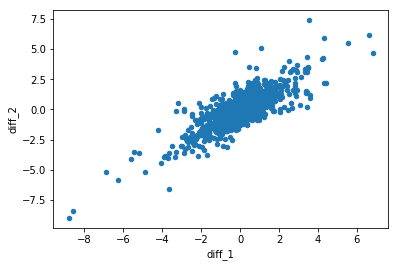

In [25]:
for_plot = pd.DataFrame()
for_plot['diff_1'] =diff1
for_plot['diff_2'] = diff2
for_plot.plot.scatter(x='diff_1',y='diff_2')

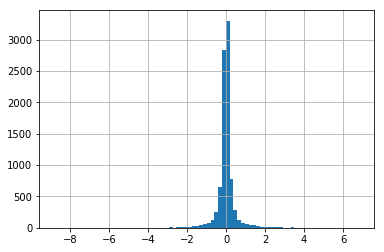

In [22]:
diff1.hist(bins=80)

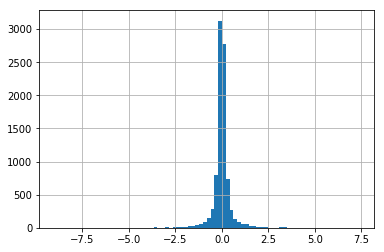

In [23]:
diff2.hist(bins=80)

In [12]:
df[['ID','y','avg_value','rolling_eight_y']].head(30)

,ID,y,avg_value,rolling_eight_y
0,1,NaN,1.437752,1.565163
1,9,NaN,1.437752,1.702038
2,10,1.437752,1.692575,1.834181
3,11,1.692575,1.706770,1.928065
4,12,1.975787,2.031615,2.008268
5,13,NaN,2.173222,2.131430
6,14,2.370656,2.253939,2.245043
7,15,2.532091,2.575187,2.375387
8,16,2.779719,3.182235,2.911708
9,17,NaN,3.306048,3.094307


In [10]:
df['magic_feature'] = df['ID']%190

In [11]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [12]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression_l2',
#     'metric': 'mse',
#     'num_leaves': 48,
#     'max_depth':7,
#     'learning_rate': 0.03,
#     'feature_fraction': 0.7,
#     'bagging_fraction': 0.9,
#     'bagging_freq': 1,
#     'verbose': 0
# }
# local cv: 0.855421505174298

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}
# 同样的条件下，此参数设置达到local cv: 0.8575832021441638


test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]
        tst = test.copy()

#         grouper = ['bin_ls','bin_env_t','bin_board_t']
#         x = tra.groupby(grouper)['y'].agg({'target_encoding_mean':'mean',
#                                            'target_encoding_max':'max',
#                                            'target_encoding_min':'min',
#                                            'target_encoding_median':'median',
#                                            'target_encoding_var':'var',
#                                            'target_encoding_count':'count'}).reset_index()
#         tra = tra.merge(x, on=grouper, how='left')
#         val = val.merge(x, on= grouper , how ='left')
#         tst = tst.merge(x, on=grouper, how='left')
        predictor = [c for c in tra.columns.tolist() if c not in['y','is_train']]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(tst[predictor]))

print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0562304	valid's score: 0.808323
[1000]	valid's l2: 0.0559916	valid's score: 0.808652
Early stopping, best iteration is:
[906]	valid's l2: 0.0559185	valid's score: 0.808753
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0173211	valid's score: 0.883697
Early stopping, best iteration is:
[609]	valid's l2: 0.017028	valid's score: 0.884571
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	valid's l2: 0.0124002	valid's score: 0.899801
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0394038	valid's score: 0.834374
[1000]	valid's l2: 0.0377675	valid's score: 0.837283
[1500]	valid's l2: 0.0374016	valid's score: 0.837946
Early stopping, best iteration is:
[1557]	valid's l2: 0.0373847	valid's score: 0.837976
Training until validation scores don't improve for 100 rounds.
Early stopping, best i

In [16]:
#rolling时泄漏，因此线下达到0.86375，但是线上成绩只有0.7606     保留此CELL
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False)

P_A                  210467.974628
I_A                   78507.819820
I_C                   54311.394047
P_avg                 43677.939401
avg_value             20525.588066
P_C                   18401.301869
P_B                   11891.529239
I_B                    7401.080561
rolling_eight_y        2700.387545
prev_value             1102.240535
second_prev_value       228.823556
light_strength          224.347582
next_value              162.283337
V_A                     135.107378
efficiency_B            123.106208
efficiency_C            122.719425
wind_direction           96.602277
board_t                  89.586767
efficiency               87.866483
wind_speed               64.104611
efficiency_A             56.792476
env_t                    44.159124
V_C                      43.887633
V_B                      35.453979
ID                       34.256313
interpolation_ID         25.806769
second_next_value        25.065913
magic_feature            24.417590
next_ID             

In [17]:
test['ans'] = np.mean(test_predicts, axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
#rolling时泄漏，因此线下达到0.86375，但是线上成绩只有0.7606
# test[['ID','ans']].to_csv('../result/080301_08582.csv',header=False, index=False)

In [14]:
train['diff'] = np.abs(train['y']-np.mean(val_preds,axis=0))

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
train[train['P_avg']>train['P_avg'].quantile(0.99)].sort_values(by=['P_avg'],ascending = False, inplace = False)[['ID','board_t','env_t','light_strength','I_A','V_A','V_B','V_C','P_avg','y','diff']]

,ID,board_t,env_t,light_strength,I_A,V_A,V_B,V_C,P_avg,y,diff
1722,1894,0.24,6.5,30,7.10,74,65350,22,160151.37,0.780917,0.801991
1065,1173,-5.83,-13.2,233,7.04,65408,22,250,158484.77,7.753474,0.044811
14,22,-10.77,-15.8,100,7.19,65382,7,107,158302.85,5.440741,1.456238
1178,1286,0.44,-68.3,100,7.18,310,307,65438,158089.59,4.694385,0.198282
1373,1519,0.25,6.5,9,7.04,77,65387,14,157912.11,0.839478,0.398626
3313,3607,-11.62,-11.5,66,7.09,65420,15,68,157829.65,0.286621,0.978684
1237,1362,-3.70,-15.1,233,7.00,65386,23,244,157793.07,7.806384,0.078358
3311,3605,-11.62,-11.5,66,7.01,65420,11,67,155300.48,0.278587,0.850097
3318,3612,0.72,33.6,69,7.13,37,65422,5,154903.24,0.192079,0.669109
3429,3723,0.12,-90.8,91,7.21,39,42,65440,154630.97,0.460215,0.630022
